In [165]:
import numpy as np

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# text processing libraries
import re
import string
import nltk

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

In [166]:
# get test and train data
df = pd.read_csv('Train.csv')
dftest = pd.read_csv('Test.csv')

In [167]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [169]:
df = df.dropna()

In [170]:
df.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [171]:
# Target column

In [172]:
df['target'].value_counts()

0    2884
1    2196
Name: target, dtype: int64

<AxesSubplot:ylabel='target'>

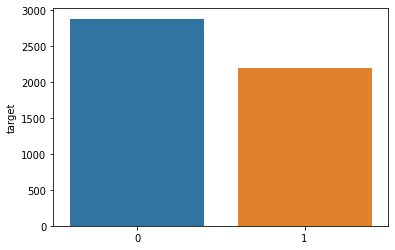

In [173]:
sns.barplot(df['target'].value_counts().index,df['target'].value_counts())

In [174]:
df['text'][:5]


31    @bbcmtd Wholesale Markets ablaze http://t.co/l...
32    We always try to bring the heavy. #metal #RT h...
33    #AFRICANBAZE: Breaking news:Nigeria flag set a...
34                   Crying out for more! Set me ablaze
35    On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
Name: text, dtype: object

# Data Cleaning

In [175]:
import re
from nltk.corpus import stopwords

stopwords_eng = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower() # convert to lowercase
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'', text) # remove url
    #remove mentions
    text = re.sub(r"(?:\@)\w+", '', text)
    text = re.sub("[^a-z]", " ", text) # replace nt aplphabets with " "
    return text

df['text'] = df['text'].apply(lambda x: clean_text(x))
dftest['text'] = dftest['text'].apply(lambda x: clean_text(x))
X_train.head()

0    our deeds are the reason of this  earthquake m...
1               forest fire near la ronge sask  canada
2    all residents asked to  shelter in place  are ...
3           people receive  wildfires evacuation or...
4    just got sent this photo from ruby  alaska as ...
Name: text, dtype: object

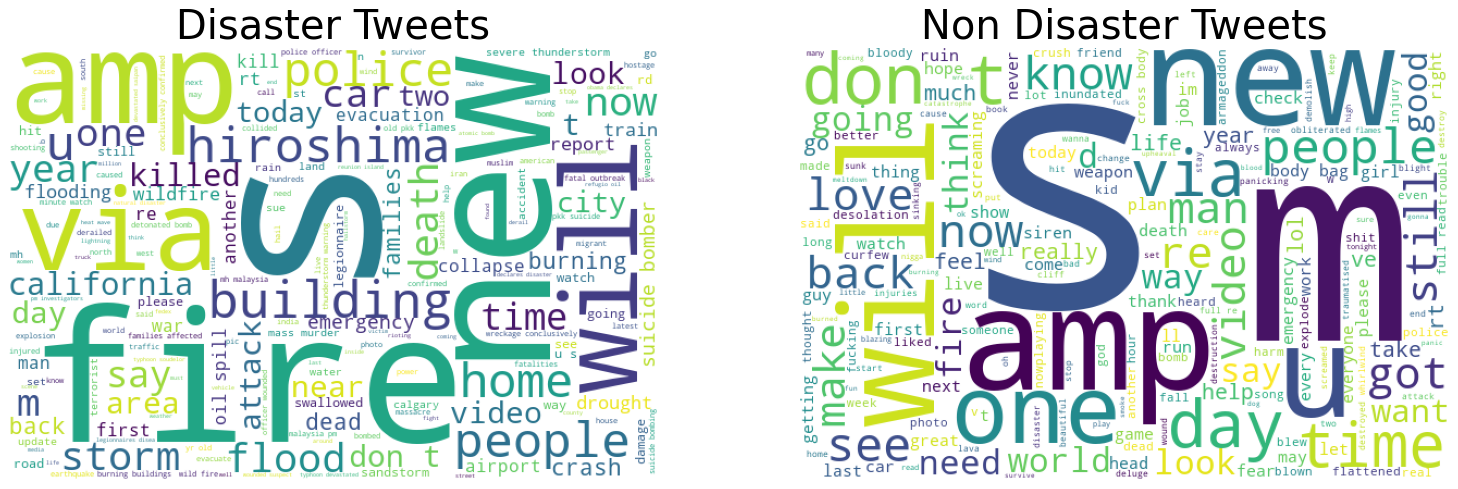

In [176]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

# A disaster tweet
disaster_tweets = df[df['target']==1]['text']


wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

#not a disaster tweet
non_disaster_tweets = df[df['target']==0]['text']


wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

# Stopwords Removal

In [183]:
from nltk.corpus import stopwords

In [184]:
def remove_stopwords(text):
    words = [w for w in text.split() if w not in stopwords.words('english')]
    return " ".join(words)

In [185]:
df['text'].head().apply(lambda x : remove_stopwords(x))

0                             wholesale markets ablaze
1                      always try bring heavy metal rt
2    africanbaze breaking news nigeria flag set abl...
3                                    crying set ablaze
4                 plus side look sky last night ablaze
Name: text, dtype: object

In [186]:
df['text'] = df['text'].apply(lambda x : remove_stopwords(x))
dftest['text'] = dftest['text'].apply(lambda x : remove_stopwords(x))
df.head()

,id,keyword,location,text,target
0,48,ablaze,Birmingham,wholesale markets ablaze,1
1,49,ablaze,Est. September 2012 - Bristol,always try bring heavy metal rt,0
2,50,ablaze,AFRICA,africanbaze breaking news nigeria flag set abl...,1
3,52,ablaze,"Philadelphia, PA",crying set ablaze,0
4,53,ablaze,"London, UK",plus side look sky last night ablaze,0


In [187]:
df = df.reset_index(drop=True)
dftest = dftest.reset_index(drop=True)

In [188]:
df.head()

,id,keyword,location,text,target
0,48,ablaze,Birmingham,wholesale markets ablaze,1
1,49,ablaze,Est. September 2012 - Bristol,always try bring heavy metal rt,0
2,50,ablaze,AFRICA,africanbaze breaking news nigeria flag set abl...,1
3,52,ablaze,"Philadelphia, PA",crying set ablaze,0
4,53,ablaze,"London, UK",plus side look sky last night ablaze,0


# Converting sentences into vectors

In [189]:
# TFIDF approach 
# rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short, 

In [190]:
# Term Frequency: is a scoring of the frequency of the word in the current document.
# TF = (Number of times term t appears in a document)/(Number of terms in the document)

In [191]:
# Inverse Document Frequency: is a scoring of how rare the word is across documents.
# IDF = 1+log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.

In [192]:
TfidfVectorizer?

In [193]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
# max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
# min_df = 2 means "ignore terms that appear in less 2 than documents".
train_tfidf = tfidf.fit_transform(df['text'])
test_tfidf = tfidf.transform(dftest["text"])

# Naive Bayes Classifier

In [196]:
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, df["target"], cv=5, scoring="f1")
scores

array([0.60818713, 0.60769231, 0.6167979 , 0.54705882, 0.7195122 ])

In [195]:
clf_NB_TFIDF.fit(train_tfidf, df["target"])

MultinomialNB()

# XGBoost

In [153]:
import xgboost as xgb
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, df["target"], cv=5, scoring="f1")
scores

[09:19:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:19:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:19:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:19:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

array([0.48445172, 0.42622951, 0.40909091, 0.38741722, 0.51183432])

In [154]:
# xgb boost score is very low compared to naive bayes

In [155]:
# Logistic regression

In [158]:
clf_tfidf = LogisticRegression(C=0.8)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, df["target"], cv=5,scoring="f1")
scores

array([0.53144654, 0.49702381, 0.50588235, 0.37225042, 0.64697609])

# Predictions

In [159]:
predictions = clf_NB_TFIDF.predict(test_tfidf)

In [160]:
results = pd.DataFrame({ "id": dftest.id.values,"target": predictions})
results.to_csv("submission.csv")

In [113]:
results.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
